In [1]:
import dynesty 
import numpy as np
import scipy
import corner
from functools import partial
import jax 

from jax import jit, grad
import jax.numpy as jnp
import jax.scipy.stats as stats

In [2]:
class onePrior():
    def __init__(self, mu: np.ndarray, cov: np.ndarray):
        self.mu = mu
        self.cov = cov
        self.cSqrt = np.sqrt(cov)
        self.ndim = len(mu)
        
    def print(self):
        print(f'Mean is : {mu}')
        print(f'Covariance is : {cov}')
        
    def scale(self, u: np.ndarray) -> np.ndarray:
        t = stats.norm.ppf(u)  # convert to standard normal
        x = jnp.dot(self.cSqrt, t)  # correlate with appropriate covariance
        return x + self.mu # add mean

In [3]:
mu = np.array([1,1,1])
cov = np.eye(3, 3)

p = onePrior(mu, cov)

p.print()

Mean is : [1 1 1]
Covariance is : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [4]:
p.scale(np.array([0.5, 0.75, 0.5]))

DeviceArray([1.       , 1.6744897, 1.       ], dtype=float32)

In [5]:
ps = [onePrior(jnp.array(n + np.random.randn(3)), cov) for n in np.random.randn(10, 3)]

In [6]:
class priorTransform():
    def __init__(self, priors: list[onePrior]):
        self.priors = priors
        
    @partial(jit, static_argnums=(0,))
    def __call__(self, u: np.ndarray) -> np.ndarray:
        x = jnp.copy(u)
        pointer = 0
        for p in self.priors:
            x.at[pointer: pointer+p.ndim].set(p.scale(u[pointer: pointer+p.ndim]))
            pointer += p.ndim
            
        x.at[-2].set(u[-2] * 2 + 0.5)
        x.at[-1].set(stats.norm.ppf(u[-1]))
        a, b = 2.0, 2.0  # shape parameters
        x.at[-4].set(u[-4] * 2 + 0.5)
        x.at[-3].set(stats.norm.ppf(u[-3]))
        return x

nps = 4
ptform = priorTransform(ps)

In [7]:
class likelihood():
    def __init__(self):
        pass
    
    @partial(jit, static_argnums=(0,))
    def __call__(self, p: np.ndarray):
        return np.sum(stats.norm.logpdf(p[:-4:3], p[-1], p[-2]))
    ''' + \
                np.sum(stats.norm.logpdf(p[1:-4:3], p[-3], p[-4]))'''
    
loglike = likelihood()

In [8]:
from dynesty import NestedSampler

# initialize our nested sampler
sampler = NestedSampler(loglike, ptform, 34, nlive=1500)

'''sampler = NestedSampler(loglike, ptform, 34, nlive=1500, 
                       gradient=grad(loglike), compute_jac=True)'''

'sampler = NestedSampler(loglike, ptform, 34, nlive=1500, \n                       gradient=grad(loglike), compute_jac=True)'

In [9]:
%%time 
sampler.run_nested()

iter: 3000 | bound: 0 | nc: 1 | ncall: 11128 | eff(%): 26.959 | loglstar:   -inf < -4.095 <    inf | logz: -6.704 +/-  0.031 | dlogz: 11.689 >  1.509                                                 IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iter: 41330 | +1500 | bound: 67 | nc: 1 | ncall: 7453696 | eff(%):  0.575 | loglstar:   -inf < 27.036 <    inf | logz: -1.692 +/-  0.272 | dlogz:  0.002 >  1.509                                     

CPU times: user 2min 39s, sys: 2min 4s, total: 4min 43s
Wall time: 2min 12s


In [10]:
sampler_grad = NestedSampler(loglike, ptform, 34, nlive=1500, 
                       gradient=grad(loglike), compute_jac=True)

In [11]:
%%time 
sampler_grad.run_nested()

iter: 3000 | bound: 0 | nc: 14 | ncall: 11065 | eff(%): 27.113 | loglstar:   -inf < -4.196 <    inf | logz: -6.757 +/-  0.031 | dlogz: 10.418 >  1.509                                                IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iter: 5409 | bound: 0 | nc: 63 | ncall: 54143 | eff(%):  9.990 | loglstar:   -inf < -1.541 <    inf | logz: -4.873 +/-  0.036 | dlogz:  6.928 >  1.509                                                /Users/grd/Repos/neneneststst/env/lib/python3.9/site-packages/dynesty/sampling.py:916: RuntimeWarning: invalid value encountered in divide
  vel_ref = vel - 2 * h * np.dot(vel, h) / linalg.norm(h)**2
/Users/grd/Repos/neneneststst/env/lib/python3.9/site-packages/dynesty/sampling.

Exception while calling gradient function:
  params: [0.5232258  0.3996849  0.9912853  0.3657398  0.83894485 0.04018629
 0.13489296 0.2847852  0.63491255 0.31787264 0.47801778 0.38321772
 0.4993838  0.15600567 0.18292426 0.46484232 0.21555942 0.0545231
 0.08610991 0.62557906 0.8828297  0.27568516 0.41346422 0.65128356
 0.57635796 0.02428756 0.44516838 0.39930862 0.43830806 0.50757027
 0.33353022 0.03640592 0.16955942 0.2423743 ]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [12]:
results = sampler.results

In [13]:
new_samples = results.samples_equal()

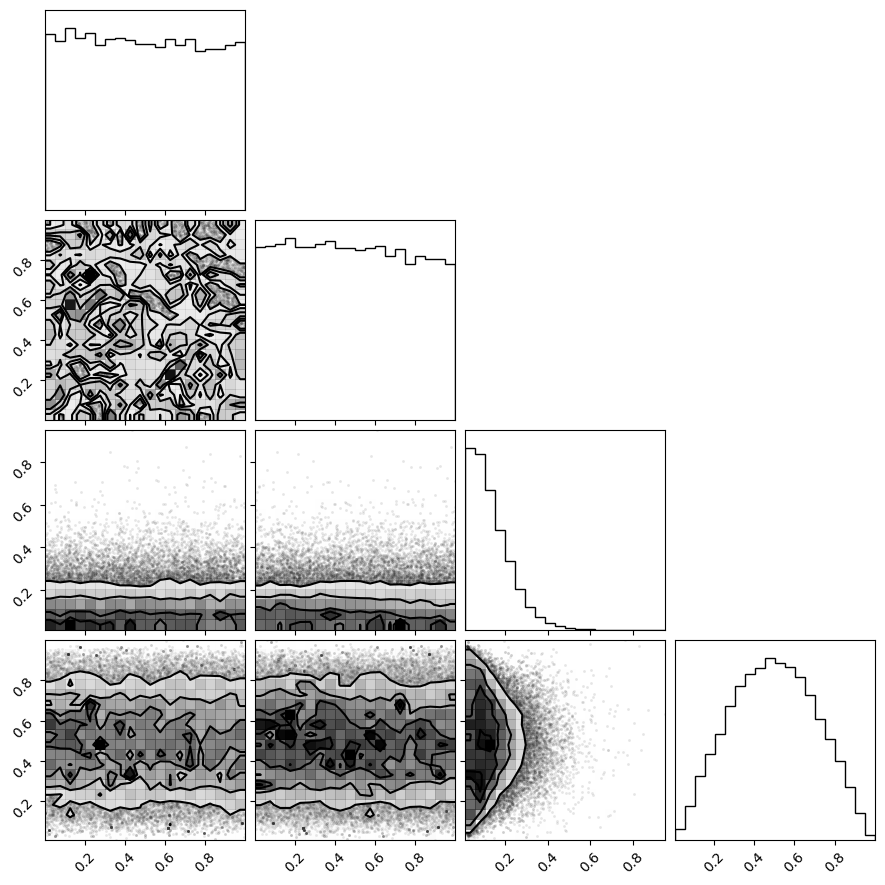

In [14]:
corner.corner(new_samples[..., -4:]);